# Illustration of JAX-cosmo on a DES Y1-like analysis

## With bayesfast!

In [1]:
#!git clone https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git

In [2]:
#!pip install ./jax_cosmo

Processing ./jax_cosmo
  Stored in directory: /tmp/pip-ephem-wheel-cache-k12y86x7/wheels/c1/39/c7/6493199f5b42df62b77da44e4be0f4b293f4ead6183b21362a
Successfully built jax-cosmo
  Found existing installation: jax-cosmo 0.1rc4.dev18+g40a961e
    Uninstalling jax-cosmo-0.1rc4.dev18+g40a961e:
      Successfully uninstalled jax-cosmo-0.1rc4.dev18+g40a961e


In [3]:
%pylab inline
import os
from distributed import Client, LocalCluster

import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

Populating the interactive namespace from numpy and matplotlib


In [4]:
#misc bayesfast setup
_nonlinear_indices=onp.array([0,1,2,3,4,5,14,15],dtype=onp.int) #selection of cosmo params + A_IA, eta_IA 
_constrained_indices = onp.array([0,1,5,14,15],dtype=onp.int)
useIS=False
n_IS = 2000 #probably can reduce a lot
os.environ['OMP_NUM_THREADS'] = '1' 

cluster = LocalCluster(n_workers=16, threads_per_worker=1) #Usually 64 threads but was dropping workers on shared...
client = Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:45375 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 540.15 GB


## Retrieving  the nz data

In [5]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)

Text(0.5, 1.0, 'Source redshift distributions')

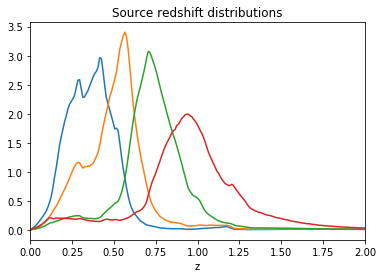

In [6]:
# Let's plot the NZs
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')


In [7]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

/global/homes/j/jsull/.conda/envs/cosmosis-nb/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(0, 2)

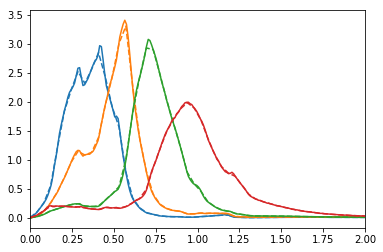

In [8]:
z = linspace(0,2)
for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)


##  Let's build  a model for C_ell

In [9]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [DeviceArray(1., dtype=float32), DeviceArray(2., dtype=float32)])

In [10]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

/global/homes/j/jsull/.conda/envs/cosmosis-nb/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/global/homes/j/jsull/.conda/envs/cosmosis-nb/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [11]:
## Let's get the covariance
f_sky = 1321./41253.
print("f_sky", f_sky)
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky)
    
    return cov

f_sky 0.03202191355780186


In [12]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [13]:
# Let's try it out
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()
fid_params = get_params_vec(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.])

In [14]:
fid_params

DeviceArray([ 0.801 ,  0.2545,  0.0485,  0.682 ,  0.971 , -1.    ,
              0.012 ,  0.012 ,  0.012 ,  0.012 ,  0.001 , -0.019 ,
              0.009 , -0.018 ,  0.5   ,  0.    ], dtype=float32)

In [15]:
cl_wl = mu(fid_params)

/global/homes/j/jsull/.conda/envs/cosmosis-nb/lib/python3.7/site-packages/jax/lax/lax.py:5222: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [16]:
%timeit mu(fid_params).block_until_ready()

385 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


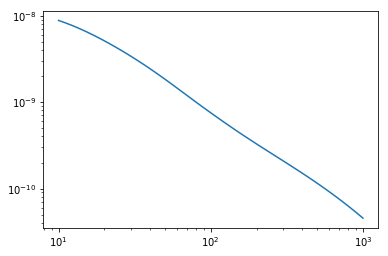

In [17]:
loglog(ell, cl_wl[0])

In [18]:
C = cov(fid_params)

In [19]:
inv_C = onp.linalg.inv(C) #need inv covariance

In [20]:
import numpy as onp

In [21]:
onp.all(onp.linalg.eigvals(inv_C).imag ==0.)

True

In [22]:
#%timeit jacobian(fid_params).block_until_ready()

In [23]:
@jax.jit
def model_fn(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
    return cl.flatten()

In [24]:

from jax import grad
@jax.jit
def model_jac(p): #not sure why doing this...
    jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))
    return jacobian(p)

In [25]:
#need to wrap these because bayesfast wants to write to the output arrays, which is not allowed in jax
def wrap_fn(p):
    return onp.asarray(model_fn(p))

def wrap_jac(p):
    return onp.asarray(model_jac(p))

## Model for bayesfast

In [59]:
#copied from the numpyro that was here before
priors = onp.array([[.012,.023],
                  [.012,.023],
                  [.012,.023],
                  [.012,.023],
                  [0.001, 0.016],
                  [-0.019, 0.013],
                  [0.009, 0.011],
                  [-0.018, 0.022],
                  ])

_prior_mu,_prior_sig = priors[:,0],priors[:,1]

para_range = onp.concatenate([onp.array([
                  [.4,1.],
                  [.1,.9],
                  [.03,.07],
                  [.55,.9],
                  [.87,1.97],
                  [-2.0,-.33]]),
                  onp.array([[p[0]-5.*p[1],p[0]+5.*p[1]] for p in priors]), #5sigma range for gaussian
                  onp.array([[-5., 5.],
                  [-5., 5.]])]
                  )

#gaussian priors
_prior_indices = onp.arange(6,14)
_flat_indices = onp.setdiff1d(np.arange(16),_prior_indices)

#init values for sample from MVG
init_mu = onp.concatenate([
                            (para_range[:6,0]+para_range[:6,1])/2,
                            _prior_mu,
                            (para_range[14:,0]+para_range[14:,1])/2,
])
init_sig = (para_range[:, 1] - para_range[:, 0]) / 1000


In [82]:
#"data" which is close to fiducial
onp.random.seed(0)
fake_data_params = onp.random.multivariate_normal(fid_params, np.diag(init_sig**2))
print(fake_data_params)

_d = wrap_fn(fake_data_params)
_d.shape

#copied from cosmosis 2pt like but is just gaussian lhood
sign, log_inv_det = onp.linalg.slogdet(inv_C)
log_det = -log_inv_det
_norm = -0.5 * log_det
nData = _d.shape[0]
nParams = fid_params.shape[0]

[ 0.80041363  0.25599405  0.04851335  0.68233251  0.973465   -0.99836551
  0.01203313  0.01209444  0.01196519  0.01197626  0.00112177 -0.01898418
  0.00904882 -0.01768006  0.51764052  0.00400157]


In [83]:
from scipy.stats import norm

_prior_norm = (
    -0.5 * onp.sum(onp.log(2 * np.pi * _prior_sig**2)) - onp.sum(onp.log(
    norm.cdf(para_range[_prior_indices, 1], _prior_mu, _prior_sig) -
    norm.cdf(para_range[_prior_indices, 0], _prior_mu, _prior_sig))) - 
    onp.sum(onp.log(para_range[_flat_indices,1] - para_range[_flat_indices,0])) 
              )

def prior_f(x): #prior chisq + log prior
    chi2 = -0.5 * onp.sum(((x[_prior_indices] - _prior_mu) / _prior_sig)**2)
    return chi2 + _prior_norm

def prior_j(x): #prior gradient
    foo = onp.zeros((1, nParams))
    foo[0, _prior_indices] = -(x[_prior_indices] - _prior_mu) / _prior_sig**2
    return foo


def chi2_f(m): #lhood chisq, uses covariance now
    m = onp.asarray(m)
    return onp.atleast_1d(-0.5 * ((m - _d).T @ inv_C @ (m - _d)) + _norm) #no longer using square root since is noisy and produces complex

def chi2_fj(m): #lood chisq gradient
    m = onp.asarray(m)
    return (onp.atleast_1d(-0.5 * ((m - _d).T @ inv_C @ (m - _d)) + _norm), 
           -((m - _d).T @ inv_C)[onp.newaxis])

def post_f(like, x): #like+prior
    return like + prior_f(x)

def post_fj(like, x): #like + prior and prior gradients
    return like + prior_f(x), onp.concatenate(
        (onp.ones((1, 1)), prior_j(x)), axis=-1)


In [96]:
import bayesfast as bf
#trying first without gradient (i.e. FD)
#m_0 = bf.Module(fun=wrap_fn, input_vars='x', #parameters-> theory model - NO GRAD
m_0 = bf.Module(fun=wrap_fn, jac=wrap_jac,input_vars='x', #parameters-> theory model - GRAD
                output_vars='m')
m_1 = bf.Module(fun=chi2_f, fun_and_jac=chi2_fj, #theory model -> likelihood 
                input_vars='m', output_vars='like')
m_2 = bf.Module(fun=post_f, fun_and_jac=post_fj, #likelihood and parameters -> log posterior
                input_vars=['like', 'x'], output_vars='logp')

In [97]:
d_0 = bf.Density(density_name='logp', module_list=[m_0, m_1, m_2], #stack modules to go from params -> log posterior
                 input_vars='x', var_dims=nParams, var_scales=para_range, 
                 hard_bounds=True)
d_0(fid_params) #not sure if this is too large?


array(10293.18796921)

In [98]:
print('Checking size of polynomial inputs. There are {0} model parameters and {1} data points'.format(nParams,nData))
s_0 = bf.modules.PolyModel('linear', nParams, nData, input_vars='x', #approximate theory model with linear model
                           output_vars='m', var_scales=para_range)
pc_0 = bf.modules.PolyConfig('linear') #another linear model
pc_1 = bf.modules.PolyConfig('quadratic', input_mask=_nonlinear_indices) #nonlinear model - quadratic
s_1 = bf.modules.PolyModel([pc_0, pc_1], nParams, nData, input_vars='x', #approximate theory model as linear + quadratic
                           output_vars='m', var_scales=para_range)


Checking size of polynomial inputs. There are 16 model parameters and 500 data points


In [99]:
#check if in bounds provided by ranges in values.ini
def _in_bound(xx, bound):
    xxt = onp.atleast_2d(xx).T
    return onp.product([onp.where(xi>bound[i,0], True, False) * 
                       onp.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xxt)], axis=0).astype(bool)


#setting up steps in recipe
opt_0 = bf.recipe.OptimizeStep(s_0, alpha_n=2,hmc_options={"sampler_options":{"max_treedepth":5},
                                                           "n_iter":1000,
                                                           "n_warmup":200}) #linear model for optimizer
sam_0 = bf.recipe.SampleStep(s_1, alpha_n=2, reuse_steps=1,  #linear+quadratic sample step
                             fit_options={'use_mu_f': True},sample_options={"sampler_options":{"max_treedepth":5},
                                                                            "n_iter":1000,
                                                                            "n_warmup":200})
sam_1 = bf.recipe.SampleStep(s_1, alpha_n=2, reuse_steps=1, #linear+quadratic sample step
                             fit_options={'use_mu_f': True},sample_options={"sampler_options":{"max_treedepth":8},
                                                                            "n_iter":1000,
                                                                            "n_warmup":200})
#surrogate model training points
x_0 = bf.utils.random.multivariate_normal(init_mu, np.diag(init_sig**2), 100)
x_0 = x_0[_in_bound(x_0, para_range)] #checking that points are inside bounds

if(not useIS):
    r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, 
                       sample=[sam_0, sam_1],
                       x_0=x_0, 
                       random_state=1)
else:
    pos_0 = bf.recipe.PostStep(n_is=n_IS, k_trunc=0.25) #post step - importance sampling

    r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, #putting it all together
                           sample=[sam_0, sam_1],
                           post=pos_0, 
                           x_0=x_0, 
                           random_state=1)


In [100]:
# import jaxlib
# jaxlib.__version__

In [101]:
import time
time.strftime('%H:%M%p %Z on %b %d, %Y')

'22:28PM PDT on May 17, 2020'

In [102]:
r_0.run()

 OptimizeStep proceeding: iter #0 finished.
 OptimizeStep proceeding: iter #1 finished, while delta_pp = 11.072, delta_pq = -12.443.
 OptimizeStep proceeding: iter #2 finished, while delta_pp = 14.108, delta_pq = -0.816.
 OptimizeStep proceeding: iter #3 finished, while delta_pp = 0.770, delta_pq = -0.022.
 OptimizeStep proceeding: iter #4 finished, while delta_pp = 0.018, delta_pq = -0.000.

 ***** OptimizeStep finished. ***** 

 CHAIN #1 : sampling proceeding [ 200 / 1000 ], last 200 samples used 7.79 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 200 / 1000 ], last 200 samples used 8.05 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 200 / 1000 ], last 200 samples used 8.14 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 200 / 1000 ], last 200 samples used 8.17 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 1000 ], last 200 samples used 8.19 seconds.
 CHAIN #3 : sampling proceeding [ 400 / 1000 ], last 200 samples used 8.24 seconds.
 CHAIN #2 : sampling proce

/global/u2/j/jsull/code/y3x2pt_fresh/y3-3x2pt-methods/cosmosis/y3_notebook_v1/bayesfast/bayesfast/core/recipe.py:689: RuntimeWarning: invalid value encountered in greater
  i_p = (_logp_all > _logq_min)


 CHAIN #1 : sampling proceeding [ 200 / 1000 ], last 200 samples used 9.01 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 200 / 1000 ], last 200 samples used 9.50 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 200 / 1000 ], last 200 samples used 9.66 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 200 / 1000 ], last 200 samples used 10.24 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 1000 ], last 200 samples used 9.28 seconds.
 CHAIN #0 : sampling proceeding [ 400 / 1000 ], last 200 samples used 9.51 seconds.
 CHAIN #3 : sampling proceeding [ 400 / 1000 ], last 200 samples used 9.88 seconds.
 CHAIN #2 : sampling proceeding [ 400 / 1000 ], last 200 samples used 11.98 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1000 ], last 200 samples used 9.29 seconds.
 CHAIN #0 : sampling proceeding [ 600 / 1000 ], last 200 samples used 9.65 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1000 ], last 200 samples used 10.00 seconds.
 CHAIN #2 : sampling proceeding [ 600

In [104]:
time.strftime('%H:%M%p %Z on %b %d, %Y')

'22:39PM PDT on May 17, 2020'

In [105]:
r_0.get()._fields

('samples', 'weights', 'logp', 'logq', 'samples_raw', 'weights_raw')

In [112]:
np.save('v21_grad_jaxcosmo_samples_noIS.npy',r_0.get().samples)
np.save('v21_grad_jaxcosmo_weights_noIS.npy',r_0.get().weights)

In [113]:
#plots - bayesfast linear+quadratic approx to posterior (with and without importance sampling)
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
labels = ['\\sigma_{8}',
          '\\Omega_c', 
          'w_{0}',
          'A_{ \\rm IA}', 
          '\\eta_{\\rm IA}'
         ] 
names = ["x%s"%i for i in range(len(labels))]
n_CALL = r_0.n_call
markers= dict(zip(names, fake_data_params[_constrained_indices]))

Removed no burn in


/global/homes/j/jsull/.conda/envs/cosmosis-nb/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


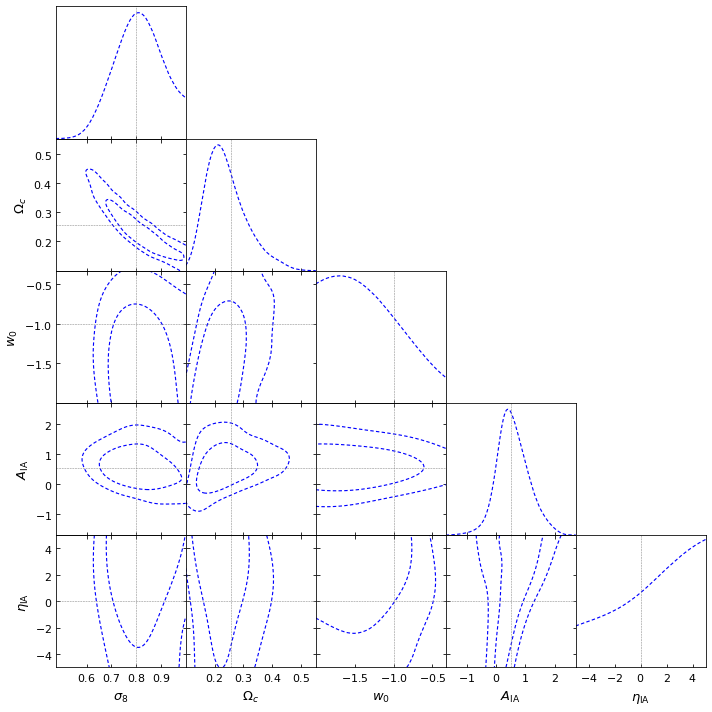

In [119]:
s_bf = MCSamples(
    samples=r_0.get().samples[:, _constrained_indices], names=names, 
    labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
    label='BayesFast 5-5-8: block quadratic model ({0} calls)'.format(n_CALL))
# s_bf_i = MCSamples(
#     samples=ngs[:, _constrained_indices],
#     #weights=r_0.get().weights, 
#     names=names, 
#     labels=labels, ranges=dict(zip(names, para_range[_constrained_indices])), 
#     label='BayesFast 5-5-8: block quadratic model with FD grad ({0} calls)'.format(n_CALL))
g = plots.getSubplotPlotter()
g.settings.figure_legend_loc = 'upper right'
g.settings.axes_fontsize = 14
g.settings.lab_fontsize = 16
g.settings.legend_fontsize = 15
g.settings.lw_contour = 2
g.settings.lw1 = 2
g.triangle_plot([s_bf], filled=False, contour_args={'alpha':1}, 
                diag1d_kwargs={'normalized':True}, contour_colors=[ 'blue',
                'green'],contour_ls=['--','-'],
                markers=markers)
plt.tight_layout()
plt.savefig('v21_grad_jax_noIS_des_y1_shear_francoisnb.png')
plt.show()